### Descrição:

#### O objetivo deste exercício é treinar e avaliar uma rede neural para classificar um conjunto de dados sobre notícias de acordo com suas categorias.
A rede neural pode ser criada utilizando o PyTorch ou Tensorflow/Keras. A rede
neural deve ser avaliada através do cálculo da acurácia (quantidade de acertos
dividido pela quantidade total de testes).


In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import datasets
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
dataset = datasets.load_dataset("okite97/news-data")

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 828
    })
})

In [5]:
dataset['train']['Excerpt'][7] # Exemplo de texto

"Nigerian Senators have commenced legislative activities for the year by asking\xa0the country's President, Muhammadu Buhari to\xa0direct\xa0the National Security Adviser, the"

In [6]:
dataset['train']['Category'][7] # Exemplo de label

'politics'

In [7]:
tokenizer = get_tokenizer('basic_english') # Tokenizador básico do torchtext

In [8]:
def split_tokens(row):
    row['tokens'] = tokenizer(row['Excerpt']) # Tokeniza o texto
    return row # Retorna o texto tokenizado

In [9]:
dataset = dataset.map(split_tokens) # Aplica a função de tokenização

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens'],
        num_rows: 828
    })
})

In [11]:
vocab = build_vocab_from_iterator(dataset['train']['tokens'], max_tokens=10000, specials=['<unk>'])  # Cria o vocabulário

vocab.set_default_index(vocab['<unk>']) # Define o índice padrão


In [12]:
def token2id(row):
    row['tokens_id'] = vocab(row['tokens']) # Transforma os tokens em índices
    return row

In [13]:
dataset = dataset.map(token2id)

In [14]:
# Codificação de rótulo para o modelo de classificação multiclasse
def category2id(row):
    if row['Category'] == 'business':
        row['Category'] = 0
    elif row['Category'] == 'entertainment':
        row['Category'] = 1
    elif row['Category'] == 'politics':
        row['Category'] = 2
    elif row['Category'] == 'sports':
        row['Category'] = 3
    elif row['Category'] == 'tech':
        row['Category'] = 4
    elif row['Category'] == 'health':
        row['Category'] = 5
    return row

dataset = dataset.map(category2id)

In [15]:
# Tranforma Category em one hot encoding
def category2onehot(row):
    if row['Category'] == 0:
        row['Category'] = [1,0,0,0,0,0]
    elif row['Category'] == 1:
        row['Category'] = [0,1,0,0,0,0]
    elif row['Category'] == 2:
        row['Category'] = [0,0,1,0,0,0]
    elif row['Category'] == 3:
        row['Category'] = [0,0,0,1,0,0]
    elif row['Category'] == 4:
        row['Category'] = [0,0,0,0,1,0]
    elif row['Category'] == 5:
        row['Category'] = [0,0,0,0,0,1]
    return row

dataset = dataset.map(category2onehot)

In [16]:
dataset['train']['Category'][7]

[0, 0, 1, 0, 0, 0]

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens', 'tokens_id'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'tokens', 'tokens_id'],
        num_rows: 828
    })
})

In [18]:
class NewsDataset(Dataset):
  def __init__(self, dataset, vocab_size): # Construtor
    self.dataset = dataset # Dicionário com os dados
    self.vocab_size = vocab_size # Tamanho do vocabulário
    self.data = dataset['tokens_id'] # Dados de entrada

  def __len__(self):
    return len(self.data) # Retorna o tamanho do dataset

  def __getitem__(self, idx): # Retorna um item do dataset
    result = torch.zeros(self.vocab_size) # Cria um vetor de zeros
    # Retorna o vetor de entrada e o rótulo
    return result.index_fill(0, torch.tensor(self.data[idx]), 1), torch.tensor(self.dataset['Category'][idx], dtype=torch.float32)

In [19]:
BATCH_SIZE = 2048  # Tamanho do batch
dataloader = DataLoader(NewsDataset(dataset['train'], len(vocab)),
                        batch_size=BATCH_SIZE, shuffle=True) # Cria o dataloader

In [20]:
dataloader

In [21]:
for X, y in dataloader:
    print('X shape: ', X.shape) # Tamanho do batch x tamanho do vocabulário
    print('y shape: ', y.shape, y.dtype) # Tamanho do batch x 1
    break

X shape:  torch.Size([2048, 10000])
y shape:  torch.Size([2048, 6]) torch.float32


In [22]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size): # Construtor
    super(TextClassifier, self).__init__() # Chama o construtor da classe pai

    self.linear_stack = nn.Sequential(
        nn.Linear(vocab_size, 16), # Camada linear de entrada 16 neurônios
        nn.ReLU(), # Função de ativação ReLU
        nn.Linear(16, 16), # Camada linear oculta
        nn.ReLU(), # Função de ativação ReLU
        nn.Linear(16, 6), # Camada linear de saída 6 classes
        nn.Softmax() # Função de ativação softmax para classificação multiclasse
    ) # Cria a pilha de camadas lineares

  def forward(self, input):
    return self.linear_stack(input) # Executa a pilha de camadas lineares

In [23]:
model = TextClassifier(len(vocab)) # Cria o modelo

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # Move o modelo para a GPU se disponível

TextClassifier(
  (linear_stack): Sequential(
    (0): Linear(in_features=10000, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=6, bias=True)
    (5): Softmax(dim=None)
  )
)

In [25]:
LR = 1e-2 # Taxa de aprendizado
EPOCHS = 25 # Número de épocas
loss_fn = nn.CrossEntropyLoss() # Função de perda
optimizer = torch.optim.Adam(model.parameters(), lr=LR) # Otimizador

In [26]:
progress_bar = tqdm(range(EPOCHS*len(dataloader))) # Cria a barra de progresso

running_loss = [] # Lista para armazenar a perda por época
for epoch in range(EPOCHS): # Loop pelas épocas

  epoch_loss = 0 # Perda por época
  for X, y in dataloader: 
    X, y = X.to(device), y.to(device) # Move os dados para a GPU se disponível
    y = torch.argmax(y, dim=1) # Converte o rótulo para o formato de classificação multiclasse

    optimizer.zero_grad() # Zera os gradientes
    y_hat = model(X) # Executa o modelo
    loss = loss_fn(y_hat, y) # Calcula a perda
    loss.backward() # Calcula os gradientes
    optimizer.step() # Atualiza os parâmetros

    epoch_loss += loss.item() # Acumula a perda
    progress_bar.update(1) # Atualiza a barra de progresso

  epoch_loss = epoch_loss / len(dataloader) # Calcula a perda média por época
  running_loss.append(epoch_loss) # Armazena a perda por época
  print('epoch loss:', epoch_loss) # Imprime a perda por época



  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  4%|▍         | 3/75 [01:41<35:54, 29.93s/it]

epoch loss: 1.7912263075510662


  8%|▊         | 6/75 [03:19<33:28, 29.11s/it]

epoch loss: 1.7748566071192424


 12%|█▏        | 9/75 [04:54<31:24, 28.55s/it]

epoch loss: 1.7473316192626953


 16%|█▌        | 12/75 [06:32<30:13, 28.79s/it]

epoch loss: 1.706578532854716


 20%|██        | 15/75 [08:08<28:26, 28.44s/it]

epoch loss: 1.6519519885381062


 24%|██▍       | 18/75 [09:44<26:52, 28.29s/it]

epoch loss: 1.5708800554275513


 28%|██▊       | 21/75 [11:18<25:07, 27.91s/it]

epoch loss: 1.4666648308436077


 32%|███▏      | 24/75 [12:50<23:10, 27.27s/it]

epoch loss: 1.355458656946818


 36%|███▌      | 27/75 [14:22<21:50, 27.30s/it]

epoch loss: 1.2579871813456218


 40%|████      | 30/75 [15:53<20:08, 26.87s/it]

epoch loss: 1.1935805082321167


 44%|████▍     | 33/75 [17:24<18:48, 26.88s/it]

epoch loss: 1.156364917755127


 48%|████▊     | 36/75 [18:56<17:34, 27.03s/it]

epoch loss: 1.1374239921569824


 52%|█████▏    | 39/75 [20:27<16:06, 26.86s/it]

epoch loss: 1.1357892751693726


 56%|█████▌    | 42/75 [21:57<14:46, 26.86s/it]

epoch loss: 1.1252669095993042


 60%|██████    | 45/75 [23:28<13:24, 26.80s/it]

epoch loss: 1.1189537048339844


 64%|██████▍   | 48/75 [25:00<12:07, 26.95s/it]

epoch loss: 1.1239902973175049


 68%|██████▊   | 51/75 [26:30<10:43, 26.80s/it]

epoch loss: 1.1151607831319172


 72%|███████▏  | 54/75 [28:02<09:26, 26.98s/it]

epoch loss: 1.1102176109949748


 76%|███████▌  | 57/75 [29:34<08:08, 27.15s/it]

epoch loss: 1.1140913168589275


 80%|████████  | 60/75 [31:04<06:42, 26.81s/it]

epoch loss: 1.102768341700236


 84%|████████▍ | 63/75 [32:36<05:24, 27.00s/it]

epoch loss: 1.0913814703623455


 88%|████████▊ | 66/75 [34:09<04:05, 27.24s/it]

epoch loss: 1.0873241821924846


 92%|█████████▏| 69/75 [35:42<02:44, 27.45s/it]

epoch loss: 1.0883523225784302


 96%|█████████▌| 72/75 [37:16<01:22, 27.54s/it]

epoch loss: 1.0818043152491252


100%|██████████| 75/75 [38:49<00:00, 27.58s/it]

epoch loss: 1.0845269362131755


In [27]:
running_loss # Imprime a lista de erro por época

[1.7912263075510662,
 1.7748566071192424,
 1.7473316192626953,
 1.706578532854716,
 1.6519519885381062,
 1.5708800554275513,
 1.4666648308436077,
 1.355458656946818,
 1.2579871813456218,
 1.1935805082321167,
 1.156364917755127,
 1.1374239921569824,
 1.1357892751693726,
 1.1252669095993042,
 1.1189537048339844,
 1.1239902973175049,
 1.1151607831319172,
 1.1102176109949748,
 1.1140913168589275,
 1.102768341700236,
 1.0913814703623455,
 1.0873241821924846,
 1.0883523225784302,
 1.0818043152491252,
 1.0845269362131755]

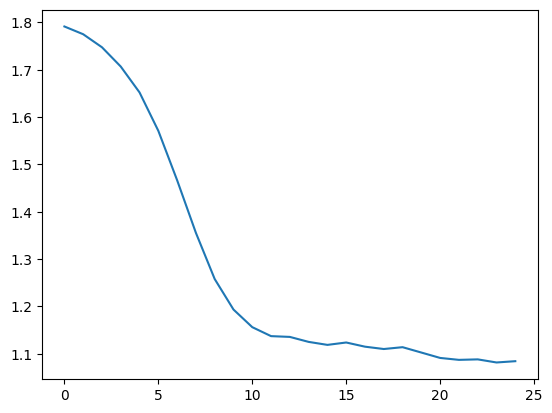

In [28]:
plt.plot(running_loss) # Plota o erro por época

In [29]:
dataloader_test = DataLoader(NewsDataset(dataset['test'], len(vocab)), batch_size=BATCH_SIZE, shuffle=True) # Cria o dataloader de teste

In [30]:
correct = 0
total = 0

for X, y in dataloader_test:
    model.eval() # Coloca o modelo em modo de avaliação
    X, y = X.to(device), y.to(device) # Move os dados para a GPU se disponível
    y = torch.argmax(y, dim=1) # Converte o rótulo para o formato de classificação multiclasse
    
    y_hat = model(X) # Executa o modelo
    y_hat = torch.argmax(y_hat, dim=1) # Converte a saída do modelo para o formato de classificação multiclasse
    
    correct += (y_hat == y).sum().item() # Calcula a acurácia
    total += y.shape[0] # Calcula o total de amostras

print('Accuracy: {:.2f}%'.format(100 * correct / total)) # Imprime a acurácia


Accuracy: 82.61%
